In [1]:
#using CUDA
using Test
using BenchmarkTools

using Plots
using LaTeXStrings
using Colors, ColorSchemes
cs1 = ColorScheme(range(colorant"red", colorant"royalblue1", length=5));
cs2 = ColorScheme(range(colorant"red", colorant"royalblue1", length=7));
cs3 = ColorScheme(range(colorant"red", colorant"darkblue", length=10));

using QuadGK

using Profile, ProfileSVG

using Base.Threads: @threads, @spawn
ENV["JULIA_NUM_THREADS"]

"64"

In [4]:
include("core/qts.jl")
#include("core/brentq.jl")
include("core/fields.jl")

psi_x_case_E (generic function with 1 method)

# Parameters

In [2]:
rho = 1.5
gamma = 5000.0
phi_m = 0.2

beta = (1-1/gamma^2)^(1/2)
lamb = 0.01/rho

# const phi_m = 0.5/rho

const sigma_z = 50e-6
const sigma_x = 50e-6

lamb_2d(z::Float64, x::Float64) = 1/(2*pi*sigma_x*sigma_z)* exp(-z^2 / 2 / sigma_z^2 - x^2 / 2 / sigma_x^2) 

lamb_2d (generic function with 1 method)

In [3]:
const rho = 1.5
const gamma = 5000.0
const phi_m = 0.2

const beta = (1-1/gamma^2)^(1/2)
lamb = 0.01/rho

# const phi_m = 0.5/rho

const sigma_z = 50e-6
const sigma_x = 50e-6

lamb_2d(z::Float64, x::Float64) = 1/(2*pi*sigma_x*sigma_z)* exp(-z^2 / 2 / sigma_z^2 - x^2 / 2 / sigma_x^2) 

lamb_2d (generic function with 1 method)

# Integration Functions (under devep)

In [4]:
include("interp.jl")

interp_will2 (generic function with 1 method)

In [75]:
ZZ = range(-5*sigma_z, 5*sigma_z, length=201)
XX = range(-5*sigma_x, 5*sigma_x, length=101)
LL = @. lamb_2d(ZZ, XX');  # 2D grid

interp_will( -4.9*sigma_z, -4.9*sigma_x,  LL, -5*sigma_z, 5*sigma_z, -5*sigma_x, 5*sigma_x)

0.0023794118080034585

In [6]:
lamb_2d(-4.9*sigma_z, -4.9*sigma_x)

0.002379411808003454

In [164]:
#function QTS_case_D(z_ob::Float64, x_ob::Float64, xp::Float64;
#        gamma::Float64, rho::Float64, phi_m::Float64, lamb::Float64, 
#        charge_grid, sigma_z::Float64, sigma_x::Float64)

function QTS_case_D2(z_ob::Float64, x_ob::Float64, 
        gamma::Float64, rho::Float64, phi_m::Float64, lamb::Float64, xp::Float64, 
        charge_grid, sigma_z::Float64, sigma_x::Float64)
    
    beta = (1-1/gamma^2)^(1/2)
    
    #M=10
    
    #ZZ = range(-5*sigma_z, 5*sigma_z, length=201)
    #XX = range(-5*sigma_x, 5*sigma_x, length=101)
    
    ## integral    
    #iii(z::Float64) =  Fx_case_B_SC((z_ob-z)/2.0/rho, (x_ob-xp)/rho, gamma)*lamb_2d(z,xp)
    #iii(z::Float64) =  Es_case_D((z_ob-z)/2.0/rho, (x_ob-xp)/rho, gamma, lamb)*lamb_2d(z,xp)
    
    #println("iii(1e-8)", iii(1e-8))
    
    #println("lamb_2d ", lamb_2d(0.0,0.0))
    
    lamb_b(z::Float64, x::Float64) = interp_will( z, x,  charge_grid, -5*sigma_z, 5*sigma_z, -5*sigma_x, 5*sigma_x)
    iii(z::Float64) =  Es_case_D((z_ob-z)/2.0/rho, (x_ob-xp)/rho, gamma, lamb)*lamb_b( z, xp )
    
    #println("lamb_b ", lamb_b(0.0,0.0))
    
    
    #lamb_b(z::Float64, x::Float64) = interp_will( z, x,  LL, -5*sigma_z, 5*sigma_z, 201, -5*sigma_x, 5*sigma_x, 101)
    #lamb_b(z::Float64, x::Float64) = interp_will( z, x,  charge_grid, -5*sigma_z, 5*sigma_z, -5*sigma_x, 5*sigma_x)
    
    #if Es_or_Fx == 1
    #    iii4(z::Float64) =  Es_case_D((z_ob-z)/2.0/rho, (x_ob-xp)/rho, gamma, lamb)*lamb_b( z, xp )
    #    println("haha")
    #else
    #    iii4(z::Float64) =  Fx_case_D((z_ob-z)/2.0/rho, (x_ob-xp)/rho, gamma, lamb)*lamb_b( z, xp )
    #    #println("kaka")
    #end
    
    #println("iii(1e-8)", iii(1e-8))
    
    #iii(z::Float64) =  Fx_case_D((z_ob-z)/2.0/rho, (x_ob-xp)/rho, gamma, lamb)*lamb_2d(z,xp)
    
    #println("iii(1e-8)", iii(1e-8))
    
    ## boundary conditions
    chi = ( x_ob - xp )/rho
    zid = rho*(phi_m + lamb - beta*sqrt(lamb^2 + chi^2 + 4*(1 + chi)*sin(phi_m/2)^2 + 2*lamb*sin(phi_m)))
    zod = rho*(lamb - beta*sqrt(lamb^2 + chi^2))
    
#####################################
    # find critical alpha

    # These came from Es_case_D

    kap(alp::Float64) = sqrt(lamb^2 + chi^2 + 4*(1+chi)*sin(alp)^2 + 2*lamb*sin(2*alp))
    N2(alp::Float64) = lamb*cos(2*alp) + (1+chi)*sin(2*alp) - beta * kap(alp)    
    
    alp_crit2_found = true
    
    alp_crit2 = find_root_Will(N2, 0.0, 0.03, 5000)
    
    if alp_crit2 == -1.0
       alp_crit2_found = false
    end

    #println("alp_crit2: ", alp_crit2)
    
    alp_crit2_usable = false

    if alp_crit2_found == true
        z_crit2  = z_ob - 2*rho*(alp_crit2 + (lamb - beta*kap(alp_crit2))/2) 
        if (z_crit2 > z_ob - zid) && (z_crit2 < z_ob - zod)
            alp_crit2_usable = true
        end
    end        
        
    
    # TESTING
    if (alp_crit2_usable == true)
        #println("ONLY USING N2 BP :", alp_crit2, ",  ",  z_crit2)

        #zp2 = z_crit2
        
        #return QTS_will(iii, z_ob - zid, z_ob - zod, 6) 
        
        i1 = QTS_will(iii, z_ob - zid, z_crit2, 6)  
        i2 = QTS_will(iii, z_crit2, z_ob - zod, 6) 
        return i1+i2
        
    else
        
        # This line is works for Case D with large enough lambda
        # In general this should be commented out
        # For Case B ( or case D with small lambda ), this should be commented out
        #return QTS_will(iii, z_ob - zid, z_ob - zod, 6) 
        
        #if (z_ob - zid < 0.0) && (0.0 < z_ob - zod)
        if (- zid < 0.0) && (0.0 < - zod)
                    
            #println("USING ZP=Z_OB as BP!!!!!!")
            
            #return QTS_will(iii, z_ob - zid, z_ob - zod, 6) 
 
            #println(" z_ob- zid:", z_ob- zid)
            #println(" z_ob- zod:", z_ob- zod)
            i1 = QTS_will(iii, z_ob - zid, z_ob, 6) 
            i2 = QTS_will(iii, z_ob, z_ob - zod, 6)
          
            out = i1+i2

            return out
            
        else
            #println("USING NO BP!!!")
            #println(" - zid:", - zid)
            #println(" - zod:", - zod)
            out = QTS_will(iii, z_ob - zid, z_ob - zod, 6) 
            #println("out:", out)
            return out
            
        end
        
    end
    
end 

QTS_case_D2 (generic function with 5 methods)

In [165]:
QTS_case_D2(1E-6, 1E-6, gamma, rho, phi_m, lamb, 1E-6, LL, sigma_z, sigma_x)

2.3544035226910385e10

In [118]:
QTS_case_D(1E-6, 1E-6, 1E-6;
        gamma=gamma, rho=1.5, phi_m=0.02, lamb=0.02, 
        charge_grid=LL, sigma_z=sigma_z, sigma_x=sigma_x)

3.031562332342124e9

In [9]:
# Profiling
#@profview QTS_case_D(1E-6, 1E-6, gamma, 0.02, 0.02, 0.0)

In [155]:
function compute_Ws_case_D(z_ob::Float64, x_ob::Float64; 
        gamma::Float64, rho::Float64, phi_m::Float64, lamb::Float64, nxp::Int, 
        charge_grid, sigma_z::Float64, sigma_x::Float64)
    
    #sigma_x  = 50e-6 
    xp_max = 5*sigma_x 
    xp_min = -5*sigma_x  
    dxp = (xp_max - xp_min)/(nxp-1)

    xp_vec = xp_min:dxp:xp_max
    
    #for testing only
    #qvec = similar(xp_vec)  
    
    sum = 0.0
    
    for i in 1:1:length(xp_vec)
        #println("xp_vec:", xp_vec[i])
        #println("integral:", qvec[i])
        #qvec[i] = QTS_case_D(z_ob, x_ob, gamma, phi_m, lamb, xp_vec[i])   
        
        #out = QTS_case_D(z_ob, x_ob, gamma, phi_m, lamb, xp_vec[i])   # for CPU only
        
        #qvec[i] = out # for testing
        #println(out)
        #sum += out
        
        sum += QTS_case_D2(z_ob, x_ob, gamma, rho, phi_m, lamb, xp_vec[i], charge_grid, sigma_z, sigma_x)
        
        #sum += QTS_case_D(z_ob, x_ob, gamma, rho, phi_m, lamb, xp_vec[i], charge_grid) 
        
        #sum += QTS_case_D(z_ob, x_ob, xp_vec[i];
        #    gamma=gamma, rho=rho, phi_m=phi_m, lamb=lamb, 
        #    charge_grid=LL, sigma_z=sigma_z, sigma_x=sigma_x)
        
    end
    
    beta = (1-1/gamma^2)^(1/2)
    
    #return qvec
    return sum* dxp*beta^2/rho^2
end

compute_Ws_case_D (generic function with 1 method)

In [156]:
compute_Ws_case_D(1E-6, 1E-6, 
    gamma=5000.0, rho = 1.5, phi_m=0.2, lamb=0.02, nxp=101, 
    charge_grid=LL, sigma_z=sigma_z, sigma_x=sigma_x)

-110402.93992759817

In [34]:
## For testing only
## Let "compute_Ws_case_D" output qvec instead of the sum
## This is useful in checking the smoothness of qvec over different xp

nxp = 501    
xp_max = 5*sigma_x 
xp_min = -5*sigma_x  
dxp = (xp_max - xp_min)/(nxp-1)

xp_vec = xp_min:dxp:xp_max;



In [35]:
qvec4 = compute_Ws_case_D(-6E-6, 6E-6, gamma, 0.2, 0.00, nxp);

In [56]:
#plot(xp_vec, qvec4)

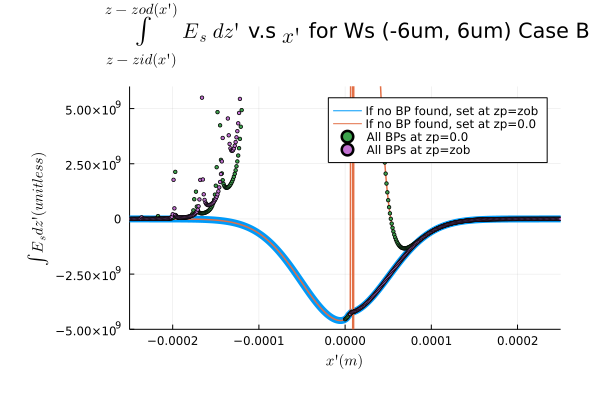

In [149]:
plot(xp_vec, qvec, label="If no BP found, set at zp=zob", linewidth = 7)
plot!(xp_vec, qvec2, label="If no BP found, set at zp=0.0", linewidth = 1.5)
plot!(xp_vec, qvec3, label="All BPs at zp=0.0", markersize = 2, seriestype = :scatter)
plot!(xp_vec, qvec4, label="All BPs at zp=zob", markersize = 2, seriestype = :scatter)

plot!(xlims=(-0.00025,0.00025))
plot!(ylims=(-5E9, 6E9))
plot!(xlabel=L"$x' (m)", ylabel=L"$\int E_s dz' (unitless)$", title=L"$\int^{z-zod(x')}_{z-zid(x')} E_s~ dz'$ v.s $x'$ for Ws (-6um, 6um) Case B")
plot!(xtickfont=font(8), ytickfont=font(8), guidefont=font(10), margin=8Plots.mm, legend = (0.55, 0.9))

In [13]:
@btime compute_Ws_case_D(1E-6, 1E-6, gamma, 0.2, 0.02, 101)

  75.320 ms (0 allocations: 0 bytes)


-110469.92471834326

In [15]:
# For profiling
#@profview compute_Ws_case_D(1E-6, 1E-6, gamma, 0.2, 0.02, 101)

# Wake computation

#### GPU simple test (4 observation points only)

In [11]:
v1 = range(1, 3, length = 3)
v2 = range(1, 3, length = 3)
f1(x,y) = x+y
L3 = @. f1(v1, v2')

3×3 Matrix{Float64}:
 2.0  3.0  4.0
 3.0  4.0  5.0
 4.0  5.0  6.0

In [16]:
function interp_simple(L3)
    z_ix = convert(Int, ceil( 1.2 )) 
    return L3[z_ix,1] 
end

interp_simple (generic function with 1 method)

In [129]:
#L3_gpu = CuArray(L3);

LL_gpu = CuArray(LL);

In [19]:
interp_will(2.5, 2.5, L3, 1, 3, 3, 1, 3, 3)

5.0

In [44]:
QTS_case_D(1E-6, 1E-6, gamma, 1.5, 0.02, 0.02, 1E-6)

3.034716146022939e9

In [26]:
interp_will( -4.9*sigma_z, -4.9*sigma_x,  LL, -5*sigma_z, 5*sigma_z, 201, -5*sigma_x, 5*sigma_x, 101)

0.0023794118080034585

In [157]:
zo_vec = CuArray([0.0, 1E-6, 2E-6, 3E-6])
#int_vec = similar(zo_vec)
Ws_vec = similar(zo_vec)

function qts_gpu!(Ws_vec, zo_vec::CuDeviceArray, lamb::Float64, LL::CuDeviceArray)
    
    v1 = range(1, 3, length = 3)
    v2 = range(1, 3, length = 3)
    #f1(x,y) = x+y
    #L3 = @. f1(v1, v2')
    
    
    index = threadIdx().x    # this example only requires linear indexing, so just use `x`
    stride = blockDim().x
    for i = index:stride:length(zo_vec)
        
        #Ws_vec[i] = interp_will( zo_vec[i], -4.9*sigma_x,  L333, -5*sigma_z, 5*sigma_z, 201, -5*sigma_x, 5*sigma_x, 101)
        #compute_Ws_case_D2(zo_vec[i], 6E-6, gamma=3000.0, rho=1.5, phi_m=0.02, lamb=0.01, nxp=101)
        
        #Ws_vec[i] = interp_simple(L3)
        #Ws_vec[i] = interp_will(zo_vec[i], 2.5, L3, 1, 3, 3, 1, 3, 3)
        
        #Ws_vec[i] = interp_will( zo_vec[i], -4.9*sigma_x,  LL, -5*sigma_z, 5*sigma_z, 201, -5*sigma_x, 5*sigma_x, 101)
        
        #Ws_vec[i] = QTS_case_D(1E-6, 1E-6, 3000.0, 1.5, 0.02, 0.02, 1E-6, LL)
        
        #Ws_vec[i] = compute_Ws_case_D2(zo_vec[i], 6E-6, gamma=3000.0, rho = 1.5, phi_m=0.2,  lamb=0.00, nxp=401, LL=LL)
        Ws_vec[i]  = compute_Ws_case_D(1E-6, 1E-6, 
            gamma=5000.0, rho = 1.5, phi_m=0.2, lamb=0.02, nxp=101, 
            charge_grid=LL, sigma_z=50E-6, sigma_x=50E-6)
    
    end
    return nothing
end

@cuda threads=4 qts_gpu!(Ws_vec, zo_vec, lamb, LL_gpu)

CUDA.HostKernel{typeof(qts_gpu!), Tuple{CuDeviceVector{Float64, 1}, CuDeviceVector{Float64, 1}, Float64, CuDeviceMatrix{Float64, 1}}}(qts_gpu!, CuContext(0x0000000004521900, instance 21688b9635860fa6), CuModule(Ptr{Nothing} @0x00000000122c64c0, CuContext(0x0000000004521900, instance 21688b9635860fa6)), CuFunction(Ptr{Nothing} @0x0000000011237300, CuModule(Ptr{Nothing} @0x00000000122c64c0, CuContext(0x0000000004521900, instance 21688b9635860fa6))), CUDA.KernelState(Ptr{Nothing} @0x0000155377c00000))

In [158]:
Ws_vec

4-element CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}:
 -110402.84405320404
 -110402.84405320404
 -110402.84405320404
 -110402.84405320404

#### GPU 2D observation grid definition 

In [17]:
nz = 201
nx = 101
AA = CuArray{Float64}(undef, nz, nx);

zv = LinRange(-5*sigma_z, 5*sigma_z, nz);
xv = LinRange(-5*sigma_x, 5*sigma_x, nx);

In [18]:
#sigma_z = 50e-6
#sigma_x = 50e-6

dz = (5*sigma_z - (-5*sigma_z))/(nz-1)
dx = (5*sigma_x - (-5*sigma_x))/(nx-1)

Δ = (dz, dx)

(2.5e-6, 5.0e-6)

### GPU computation ( indexing algorithm from Chris Mayes )

In [ ]:
compute_Ws_case_D(z, x, gamma, phi_m, 0.01, 201)

In [37]:
gamma

5000.0

In [159]:
function fillwake!(A::CuDeviceArray, Δ, charge_grid::CuDeviceArray, gamma)
    
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x
    
    dz, dx = Δ
    nz, nx =  size(A) 
    for i = index:stride:length(A)
        ij = @inbounds CartesianIndices(A)[i]

        z = dz*(ij[1]-1 - (nz-1)/2)
        x = dx*(ij[2]-1 - (nx-1)/2)

        #@inbounds A[i] = f(z, x)
        
        #@inbounds A[i] = compute_Ws_case_D(z, x, gamma, phi_m, 0.01, 201)
        
        #A[i] = compute_Ws_case_D2(z, x, gamma=gamma, rho=1.5, phi_m=0.2, lamb=0.01, nxp=101, charge_grid=charge_grid)
        
        A[i] = compute_Ws_case_D(z, x, 
            gamma=5000.0, rho = 1.5, phi_m=0.2, lamb=0.02, nxp=101, 
            charge_grid=charge_grid, sigma_z=sigma_z, sigma_x=sigma_x)
    end
    
end

fillwake! (generic function with 2 methods)

In [160]:
# GPU parameters

Ncu = length(AA)
kernel = @cuda launch=false fillwake!(AA, Δ, LL_gpu, gamma)
config = launch_configuration(kernel.fun)
threads = min(Ncu, config.threads)
blocks = cld(Ncu, threads)
threads, blocks

(256, 80)

In [161]:
# Fill on the device
# This cell can take time!

CUDA.@time CUDA.@sync kernel(AA, Δ, LL_gpu; threads, blocks);

  2.903334 seconds (25.88 k CPU allocations: 1.425 MiB)


In [30]:
AA_cpu[101,51]

-140213.2542273218

In [109]:
kernel(AA, Δ, LL_gpu; threads, blocks)

In [44]:
#CUDA.@sync kernel(AA, Δ; threads, blocks);

In [45]:
# How William ran gpu

#function bench_gpu2!(AA, Δ)
#    CUDA.@sync begin
#        @cuda threads=1024 blocks=cld(length(AA), 1024) fillwake!(AA, Δ)
#    end
#end

#@time bench_gpu2!(AA, Δ)

#### Ploting GPU results

In [162]:
AA_cpu = Array(AA);

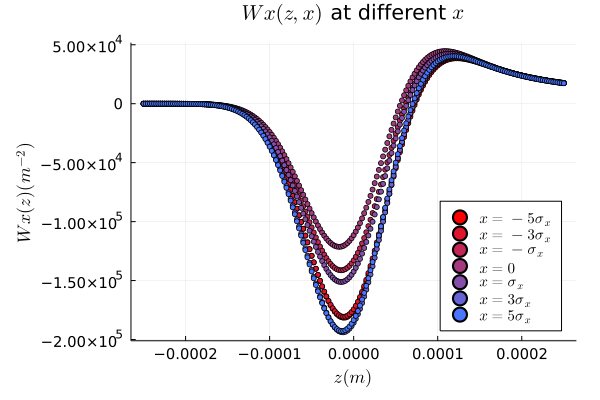

In [163]:
plot(zv, AA_cpu[:,1], linewidth=2, label=L"x=-5\sigma_x", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(zv, AA_cpu[:,21], linewidth=2, label=L"x=-3\sigma_x", markersize = 3, seriestype = :scatter, color=cs2[2])
plot!(zv, AA_cpu[:,41], linewidth=2, label=L"x=-\sigma_x", markersize = 3, seriestype = :scatter, color=cs2[3])
plot!(zv, AA_cpu[:,51], linewidth=2, label=L"x=0", markersize = 3, seriestype = :scatter, color=cs2[4])
plot!(zv, AA_cpu[:,61], linewidth=2, label=L"x=\sigma_x", markersize = 3, seriestype = :scatter, color=cs2[5])
plot!(zv, AA_cpu[:,81], linewidth=2, label=L"x=3\sigma_x", markersize = 3, seriestype = :scatter, color=cs2[6])
plot!(zv, AA_cpu[:,101], linewidth=2, label=L"x=5\sigma_x", markersize = 3, seriestype = :scatter, color=cs2[7])


plot!(xlabel=L"$z (m)", ylabel=L"$Wx(z) (m^{-2})$", title=L"$Wx(z,x)$ at different $x$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=:bottomright, legendfontsize = 10)

In [207]:
#heatmap(zv, xv, AA_cpu, xlabel="z (m)", ylabel="x (m)", title="Wx(z,x)")

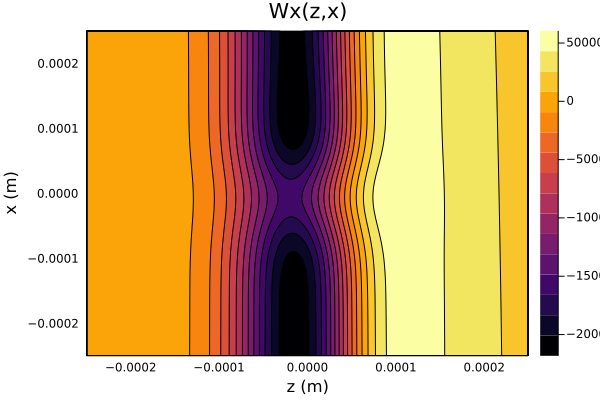

In [24]:
contourf(zv, xv, AA_cpu', xlabel="z (m)", ylabel="x (m)", title="Wx(z,x)")

### Wake computation using Multi CPU

In [163]:
function Ws_case_D_multithread_lamb(lamb; nz=31, nx=3)
    out = zeros(Float64, nz, nx)
    z_ob = range(-5*sigma_z, 5*sigma_z, length = nz)
    x_ob = range(-2*sigma_x, 2*sigma_x, length = nx)
    @sync for i in 1:nz
        @spawn for j in 1:nx
            #out[i,j] = compute_Ws_case_D(z_ob[i], x_ob[j], gamma, phi_m, lamb, 101)
            out[i,j] = compute_Ws_case_D(z_ob[i], x_ob[j], gamma, phi_m, 0.0, 101)
        end
    end
    return out
end

Ws_case_D_multithread_lamb (generic function with 1 method)

In [16]:
phi_vec = [0.04, 0.06, 0.08, 0.1, 0.2];

In [165]:
@time Ws_caseD_mat_lamb_001 = Ws_case_D_multithread_lamb(0.01, nz=201, nx=11);

  2.765959 seconds (1.24 k allocations: 145.047 KiB)


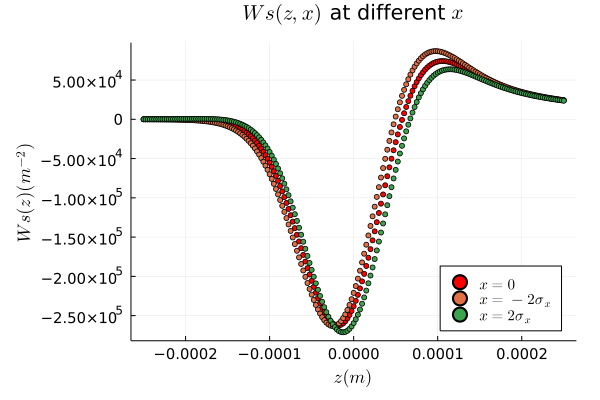

In [40]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 201)
#plot(z_ob, Ws_caseD_mat_lamb_0001[1:101], linewidth=2, label=L"\lambda =0.001")
plot(z_ob, Ws_caseD_mat_lamb_001[202:402], linewidth=2, label=L"x=0", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(z_ob, Ws_caseD_mat_lamb_001[1:201], label=L"x=-2\sigma_x", markersize = 3,  seriestype = :scatter)
plot!(z_ob, Ws_caseD_mat_lamb_001[403:603], label=L"x=2\sigma_x", markersize = 3,  seriestype = :scatter)

plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,x)$ at different $x$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=:bottomright, legendfontsize = 10)

# Below is not organized yet!!

In [459]:
@time Wx_caseD_mat_lamb_001 = Ws_case_D_multithread_lamb(0.01, nz=201, nx=101);

206.806275 seconds (1.26 M allocations: 67.716 MiB, 0.86% compilation time)


201×101 Matrix{Float64}:
   -93.1754    -87.5174    -82.161   …     78.0689     83.4242     89.0811
  -103.641     -97.4617    -91.6057        86.3736     92.228      98.4057
  -115.254    -108.512    -102.116         95.4436    101.838     108.577
  -128.147    -120.798    -113.818        105.331     112.307     119.654
  -142.468    -134.465    -126.855        116.087     123.692     131.692
  -158.387    -149.678    -141.39    …    127.762     136.045     144.749
  -176.094    -166.627    -157.607        140.405     149.418     158.879
  -195.809    -185.526    -175.719        154.06      163.859     174.133
  -217.779    -206.62     -195.966        168.766     179.41      190.558
  -242.289    -230.189    -218.624        184.553     196.104     208.19
  -269.662    -256.553    -244.01    …    201.439     213.966     227.057
  -300.27     -286.079    -272.485        219.431     233.003     247.172
  -334.537    -319.186    -304.465        238.515     253.208     268.53
     ⋮       

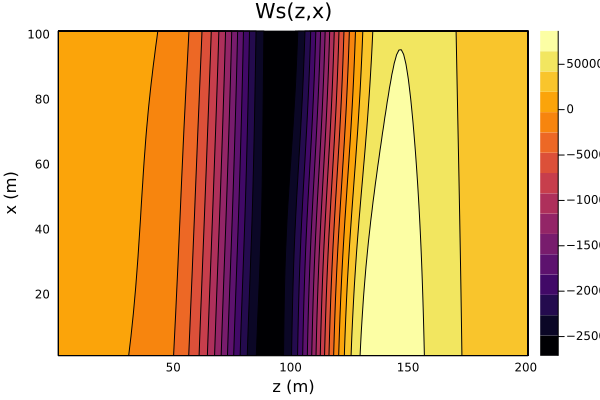

In [469]:
contourf(Wx_caseD_mat_lamb_001', xlabel="z (m)", ylabel="x (m)", title="Ws(z,x)")

In [465]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 201)

-0.00025:2.5e-6:0.00025

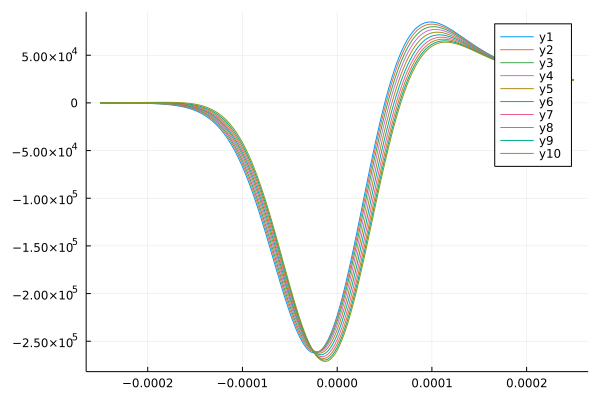

In [471]:
i=10
plot(z_ob, Wx_caseD_mat_lamb_001[1+201*i:201+201*i])
i=20
plot!(z_ob, Wx_caseD_mat_lamb_001[1+201*i:201+201*i])
i=30
plot!(z_ob, Wx_caseD_mat_lamb_001[1+201*i:201+201*i])
i=40
plot!(z_ob, Wx_caseD_mat_lamb_001[1+201*i:201+201*i])
i=50
plot!(z_ob, Wx_caseD_mat_lamb_001[1+201*i:201+201*i])
i=60
plot!(z_ob, Wx_caseD_mat_lamb_001[1+201*i:201+201*i])
i=70
plot!(z_ob, Wx_caseD_mat_lamb_001[1+201*i:201+201*i])
i=80
plot!(z_ob, Wx_caseD_mat_lamb_001[1+201*i:201+201*i])
i=90
plot!(z_ob, Wx_caseD_mat_lamb_001[1+201*i:201+201*i])
i=100
plot!(z_ob, Wx_caseD_mat_lamb_001[1+201*i:201+201*i])

In [49]:
@time Ws_caseD_mat_lamb_0 = Ws_case_D_multithread_lamb(0.01, nz=201, nx=101);

1768.849115 seconds (1.59 M allocations: 85.404 MiB, 0.01% compilation time)


In [15]:
Ws_caseD_mat_lamb_001 = Ws_case_D_multithread_lamb(0.01, nz=101, nx=3);

In [16]:
Ws_caseD_mat_lamb_002 = Ws_case_D_multithread_lamb(0.02, nz=101, nx=3);

In [17]:
Ws_caseD_mat_lamb_003 = Ws_case_D_multithread_lamb(0.03, nz=101, nx=3);

In [18]:
Ws_caseD_mat_lamb_005 = Ws_case_D_multithread_lamb(0.05, nz=101, nx=3);

In [19]:
Ws_caseD_mat_lamb_008 = Ws_case_D_multithread_lamb(0.08, nz=101, nx=3);

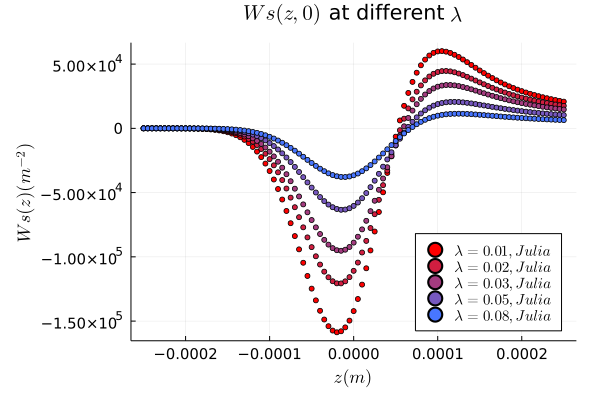

In [20]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)
#plot(z_ob, Ws_caseD_mat_lamb_0001[1:101], linewidth=2, label=L"\lambda =0.001")
plot(z_ob, Ws_caseD_mat_lamb_001[102:202], linewidth=2, label=L"\lambda =0.01, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(z_ob, Ws_caseD_mat_lamb_002[102:202], linewidth=2, label=L"\lambda =0.02, Julia", markersize = 3, seriestype = :scatter, color=cs1[2])
plot!(z_ob, Ws_caseD_mat_lamb_003[102:202], linewidth=2, label=L"\lambda =0.03, Julia", markersize = 3, seriestype = :scatter, color=cs1[3])
plot!(z_ob, Ws_caseD_mat_lamb_005[102:202], linewidth=2, label=L"\lambda =0.05, Julia", markersize = 3, seriestype = :scatter, color=cs1[4])
plot!(z_ob, Ws_caseD_mat_lamb_008[102:202], linewidth=2, label=L"\lambda =0.08, Julia", markersize = 3, seriestype = :scatter, color=cs1[5])

##plot!(z_ob, WsD_1D_vec_1, linewidth=2, label=L"\lambda =0.01, 1D~csr", color=cs1[1])
#plot!(z_ob, WsD_1D_vec_2, linewidth=2, label=L"\lambda =0.02, 1D~csr", color=cs1[2])
#plot!(z_ob, WsD_1D_vec_3, linewidth=2, label=L"\lambda =0.03, 1D~csr", color=cs1[3])
#plot!(z_ob, WsD_1D_vec_4, linewidth=2, label=L"\lambda =0.05, 1D~csr", color=cs1[4])
#plot!(z_ob, WsD_1D_vec_5, linewidth=2, label=L"\lambda =0.08, 1D~csr", color=cs1[5])


plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,0)$ at different $\lambda$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=:bottomright, legendfontsize = 10)

# Case E

##### Case E has 3 terms.
##### The far boundary term dominates over the other two terms.

#### $Ws_{integral}(zob, xob) = \int\int^{zob - znear}_{zob - zod} ws(zob-z', xob - x') \lambda_b'(z',x')dz'dx'$ ,

$zod = \rho (\lambda -\beta \sqrt{\lambda^2 + ((xob-x')/\rho)^2} )$ 

$znear = -\beta |xob - x'|$

#### $Ws_{boundary, far}(zob, xob) = \int ws(L=\rho\lambda, xob-x') \lambda_b(zob - zod, x') dx'$

#### $Ws_{boundary, near}(zob, xob) = -\int ws(L=0, xob-x') \lambda_b(zob - znear, x') dx'$

In [ ]:
zo_vec = CuArray([0.0, 1E-6, 2E-6, 3E-6])
#int_vec = similar(zo_vec)
Ws_vec = similar(zo_vec)

function qts_gpu!(Ws_vec, zo_vec::CuDeviceArray, lamb::Float64, LL::CuDeviceArray)
    
    v1 = range(1, 3, length = 3)
    v2 = range(1, 3, length = 3)
    #f1(x,y) = x+y
    #L3 = @. f1(v1, v2')
    
    
    index = threadIdx().x    # this example only requires linear indexing, so just use `x`
    stride = blockDim().x
    for i = index:stride:length(zo_vec)
        
        #Ws_vec[i] = interp_will( zo_vec[i], -4.9*sigma_x,  L333, -5*sigma_z, 5*sigma_z, 201, -5*sigma_x, 5*sigma_x, 101)
        #compute_Ws_case_D2(zo_vec[i], 6E-6, gamma=3000.0, rho=1.5, phi_m=0.02, lamb=0.01, nxp=101)
        
        #Ws_vec[i] = interp_simple(L3)
        #Ws_vec[i] = interp_will(zo_vec[i], 2.5, L3, 1, 3, 3, 1, 3, 3)
        
        #Ws_vec[i] = interp_will( zo_vec[i], -4.9*sigma_x,  LL, -5*sigma_z, 5*sigma_z, 201, -5*sigma_x, 5*sigma_x, 101)
        
        #Ws_vec[i] = QTS_case_D(1E-6, 1E-6, 3000.0, 1.5, 0.02, 0.02, 1E-6, LL)
        
        #Ws_vec[i] = compute_Ws_case_D2(zo_vec[i], 6E-6, gamma=3000.0, rho = 1.5, phi_m=0.2,  lamb=0.00, nxp=401, LL=LL)
        Ws_vec[i]  = compute_Ws_case_D(1E-6, 1E-6, 
            gamma=5000.0, rho = 1.5, phi_m=0.2, lamb=0.02, nxp=101, 
            charge_grid=LL, sigma_z=50E-6, sigma_x=50E-6)
    
    end
    return nothing
end

@cuda threads=4 qts_gpu!(Ws_vec, zo_vec, lamb, LL_gpu)

In [33]:
include("core/kick.jl")

csr2d_kick_calc_case_E (generic function with 1 method)

In [37]:
using Distributions, Random

# Fake Gaussian beam

Np = 5000000
Q = 5E-9

charges = ones(Np)*Q/Np;

bb = Array{Float64, 2}(undef, 6, Np);
Random.seed!(1234)

#bb[1,1:Np-1] = rand(Normal(0, 50E-6), Np-1);
#bb[2,1:Np-1] = rand(Normal(0, 50E-6), Np-1);
#bb[3,1:Np-1] = rand(Normal(0, 50E-6), Np-1);
#bb[4,1:Np-1] = rand(Normal(0, 50E-6), Np-1);
#bb[5,1:Np-1] = rand(Normal(0, 50E-6), Np-1);
#bb[6,1:Np-1] = rand(Normal(0, 1E-6), Np-1);

#bb[1, Np] = -0.0002666613359011983
#bb[2, Np] = 0.0
#bb[3, Np] = 0.0
#bb[4, Np] = 0.0
#bb[5, Np] = -0.00027260644226281925
#bb[6, Np] = 0.0


bb[1,1:Np] = rand(Normal(0, 50E-6), Np);
bb[2,1:Np] = rand(Normal(0, 50E-6), Np);
bb[3,1:Np] = rand(Normal(0, 50E-6), Np);
bb[4,1:Np] = rand(Normal(0, 50E-6), Np);
bb[5,1:Np] = rand(Normal(0, 50E-6), Np);
bb[6,1:Np] = rand(Normal(0, 1E-6), Np);


zmin = minimum(bb[5,:])
zmax = maximum(bb[5,:])
xmin = minimum(bb[1,:])
xmax = maximum(bb[1,:])



z_b = bb[5,:]
x_b = bb[1,:]
nz = 201
nx=101
weight = charges
zmin = minimum(z_b)
    zmax = maximum(z_b)
    xmin = minimum(x_b)
    xmax = maximum(x_b)
    
    #zmin = -5*50E-6
    #zmax = 5*50E-6
    #xmin = -5*50E-6
    #xmax = 5*50E-6
    
    dz = (zmax - zmin) / (nz - 1)
    dx = (xmax - xmin) / (nx - 1)
    Δ = (dz, dx)
    
    zv = LinRange(zmin, zmax, nz);
    xv = LinRange(xmin, xmax, nx);

    # Charge deposition
    println(" Applying charge deposition...")
    charge_grid = histogram_cic_2d(z_b, x_b, weight, nz, zmin, zmax, nx, xmin, xmax)
    
    nn = sum(charge_grid) *dz*dx
    lambda_grid = charge_grid ./ nn;

 Applying charge deposition...


In [25]:
function compute_Ws_case_E_boundary(z_ob::Float64, x_ob::Float64, gamma::Float64, lamb::Float64)
    
    M=6
    
    chi(xp::Float64) = ( x_ob - xp )/rho
    zod(xp::Float64)  = rho*(lamb - beta*sqrt(lamb^2 + chi(xp)^2))
    z_near(xp::Float64) = -beta*abs(x_ob - xp) 
    
    ## integral    
    #iii1(z::Float64) =  psi_s_case_E((z_ob-z), (x_ob-xp), gamma)*lamb_2d_dz(z,xp)
    
    println(lamb_2d(50E-6, 50E-6))
    println(lamb_2d(-50E-6, 50E-6))
    
    L_far = rho*lamb
    psi_s_case_E_far(x::Float64) = 1/(sqrt(x^2 + L_far^2) - beta*L_far)
    psi_s_case_E_near(x::Float64) = 1/abs(x)
    
    
    iii2(xp::Float64) = psi_s_case_E_far( x_ob-xp )*lamb_2d(z_ob-zod(xp), xp)
    iii3(xp::Float64) = -psi_s_case_E_near( x_ob-xp )*lamb_2d(z_ob-z_near(xp), xp)
    
    
    ifar_1 = QTS_will(iii2, -5*sigma_x, x_ob, M)       
    ifar_2 = QTS_will(iii2, x_ob, 5*sigma_x, M)     
    
    #ifar = quadgk(xp -> iii2(xp), -5*sigma_x, 5*sigma_x,  rtol=1e-4)[1]
    
    inear_1 = QTS_will(iii3, -5*sigma_x, x_ob, M)       
    inear_2 = QTS_will(iii3, x_ob, 5*sigma_x, M)       
    
    #return (ifar_1 + ifar_2)*(-1.0/gamma^2)    
    #return (inear_1 + inear_2)*(-1.0/gamma^2)  
    #return (ifar_1 + ifar_2 + inear_1 + inear_2)*(-1.0/gamma^2)  
    
    return ( ifar_2 )*(-1.0/gamma^2)

end

compute_Ws_case_E_boundary (generic function with 1 method)

In [ ]:
-38754*2

-77508

In [36]:
compute_Ws_case_E_boundary(0.0, 0.0, 5000.0, 0.01/1.5)

LoadError: UndefVarError: compute_Ws_case_E_boundary not defined

In [9]:
function QTS_case_E(z_ob::Float64, x_ob::Float64, gamma::Float64, lamb::Float64, xp::Float64)
    
    ## integral    
    iii(z::Float64) = psi_s_case_E((z_ob-z), (x_ob-xp), gamma)*lamb_2d_dz(z,xp)
    #println("iii(1e-8)", iii(1e-8))
    
    ## boundary conditions
    chi = ( x_ob - xp )/rho
    zod = rho*(lamb - beta*sqrt(lamb^2 + chi^2))
    z_near = -beta*abs(x_ob - xp)

    #println("zod:", zod)
    #println("z_near:", z_near)

    # if z_near is too close to zero, the integral blows up
    if z_near > -1E-16
        z_near = -1E-16
    end
    
    i1 = QTS_will(iii, z_ob - zod, z_ob-1E-16)
    i2 = QTS_will(iii, z_ob + 1E-16, z_ob - z_near)
    #i2 = isapprox(0.0, z_near ; atol=1e-20) ? 0.0 : QTS_will(iii, z_ob, z_ob - z_near)        
    #println("i1", i1)
    #println("i2", i2)
    
   # z_near = isapprox(0.0, z_near ; atol=1e-20) ? 1E-20, 
    
    #i_all = QTS_will(iii, z_ob - zod, z_ob-z_near)
    
    return (i1+i2)
    
    #return i_all*(-1.0/gamma^2)

    
end 

function compute_Ws_case_E_integral(z_ob::Float64, x_ob::Float64, gamma::Float64, phi::Float64, nxp::Int)
    sigma_x  = 50e-6 
    xp_max = 5*sigma_x 
    xp_min = -5*sigma_x  
    dxp = (xp_max - xp_min)/(nxp-1)

    xp_vec = xp_min:dxp:xp_max
    
    #qvec is for testing only
    qvec = similar(xp_vec)  
    
    sum = 0.0
    
    for i in 1:1:length(xp_vec)
        qvec[i] = QTS_case_E(z_ob, x_ob, gamma, phi, xp_vec[i])  # for testing
        #println("integral:", qvec[i])
        sum += QTS_case_E(z_ob, x_ob, gamma, phi, xp_vec[i])   # for CPU only  
    end
    
    #return qvec
    return sum* dxp*(-1.0/gamma^2)
end

compute_Ws_case_E_integral (generic function with 1 method)

In [10]:
# Boundary term computation is much faster than the integral term

function Ws_case_E_multithread_lamb(lamb; nz=31, nx=5)
    out = zeros(Float64, nz, nx)
    z_ob = range(-5*sigma_z, 5*sigma_z, length = nz)
    x_ob = range(-2*sigma_x, 2*sigma_x, length = nx)
    @sync for i in 1:nz
        @spawn for j in 1:nx
            out[i,j] = compute_Ws_case_E_boundary(z_ob[i], x_ob[j], gamma, lamb)
            #out[i,j] = compute_Ws_case_E_integral(z_ob[i], x_ob[j], gamma, lamb, 101)
            
            #out[i,j] = compute_Ws_case_E_integral(z_ob[i], x_ob[j], gamma, lamb, 101) + compute_Ws_case_E_boundary(z_ob[i], x_ob[j], gamma, lamb)
        end
    end
    return out
end

Ws_case_E_multithread_lamb (generic function with 1 method)

In [18]:
Ws_caseE_mat_lamb_001_s = Ws_case_E_multithread_lamb(0.01, nz=101, nx=3);

In [25]:
Ws_caseE_mat_lamb_002 = Ws_case_E_multithread_lamb(0.02, nz=101, nx=3);

In [26]:
Ws_caseE_mat_lamb_003 = Ws_case_E_multithread_lamb(0.03, nz=101, nx=3);

In [27]:
Ws_caseE_mat_lamb_005 = Ws_case_E_multithread_lamb(0.05, nz=101, nx=3);

In [13]:
Ws_caseE_mat_lamb_008 = Ws_case_E_multithread_lamb(0.08, nz=101, nx=3);

In [20]:
Ws_caseE_mat_lamb_001_s[102:202][51]

-76133.85362526872

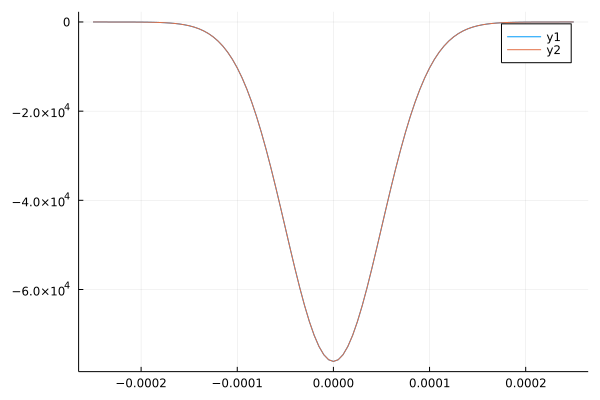

In [19]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)
plot(z_ob, Ws_caseE_mat_lamb_001_s[102:202])
plot!(z_ob, Ws_caseE_mat_lamb_001[102:202])

### Combine Case D and Case E result

In [38]:
Ws_caseDE_mat_lamb_001 = Ws_caseD_mat_lamb_001 + Ws_caseE_mat_lamb_001;
Ws_caseDE_mat_lamb_002 = Ws_caseD_mat_lamb_002 + Ws_caseE_mat_lamb_002;
Ws_caseDE_mat_lamb_003 = Ws_caseD_mat_lamb_003 + Ws_caseE_mat_lamb_003;
Ws_caseDE_mat_lamb_005 = Ws_caseD_mat_lamb_005 + Ws_caseE_mat_lamb_005;
Ws_caseDE_mat_lamb_008 = Ws_caseD_mat_lamb_008 + Ws_caseE_mat_lamb_008;

### Run 1D theory for Case D in the section at the final section

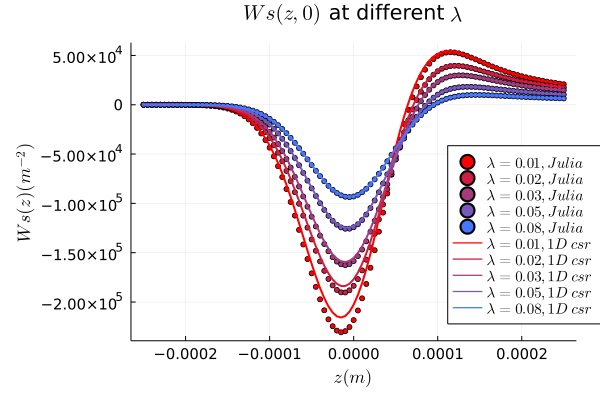

In [53]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)
#plot(z_ob, Ws_caseD_mat_lamb_0001[1:101], linewidth=2, label=L"\lambda =0.001")
plot(z_ob, Ws_caseDE_mat_lamb_001[102:202], linewidth=2, label=L"\lambda =0.01, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(z_ob, Ws_caseDE_mat_lamb_002[102:202], linewidth=2, label=L"\lambda =0.02, Julia", markersize = 3, seriestype = :scatter, color=cs1[2])
plot!(z_ob, Ws_caseDE_mat_lamb_003[102:202], linewidth=2, label=L"\lambda =0.03, Julia", markersize = 3, seriestype = :scatter, color=cs1[3])
plot!(z_ob, Ws_caseDE_mat_lamb_005[102:202], linewidth=2, label=L"\lambda =0.05, Julia", markersize = 3, seriestype = :scatter, color=cs1[4])
plot!(z_ob, Ws_caseDE_mat_lamb_008[102:202], linewidth=2, label=L"\lambda =0.08, Julia", markersize = 3, seriestype = :scatter, color=cs1[5])

plot!(z_ob, WsD_1D_vec_1, linewidth=2, label=L"\lambda =0.01, 1D~csr", color=cs1[1])
plot!(z_ob, WsD_1D_vec_2, linewidth=2, label=L"\lambda =0.02, 1D~csr", color=cs1[2])
plot!(z_ob, WsD_1D_vec_3, linewidth=2, label=L"\lambda =0.03, 1D~csr", color=cs1[3])
plot!(z_ob, WsD_1D_vec_4, linewidth=2, label=L"\lambda =0.05, 1D~csr", color=cs1[4])
plot!(z_ob, WsD_1D_vec_5, linewidth=2, label=L"\lambda =0.08, 1D~csr", color=cs1[5])


plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,0)$ at different $\lambda$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=(0.8, 0.6), legendfontsize = 10)

# Propagation from Case B to Case D
#### (Pre-saved Case B wake files required )

In [ ]:
using DelimitedFiles

#open("Ws_caseB_mat_phi_02.jl", "w") do io
#    writedlm(io, Ws_caseB_mat_phi_02)
#end

Ws_caseB_mat_phi_004 = readdlm("Ws_caseB_mat_phi_004.jl", '\t', '\n');
Ws_caseB_mat_phi_006 = readdlm("Ws_caseB_mat_phi_006.jl", '\t', '\n');
Ws_caseB_mat_phi_008 = readdlm("Ws_caseB_mat_phi_008.jl", '\t', '\n');
Ws_caseB_mat_phi_012 = readdlm("Ws_caseB_mat_phi_012.jl", '\t', '\n');
Ws_caseB_mat_phi_02 = readdlm("Ws_caseB_mat_phi_02.jl", '\t', '\n');

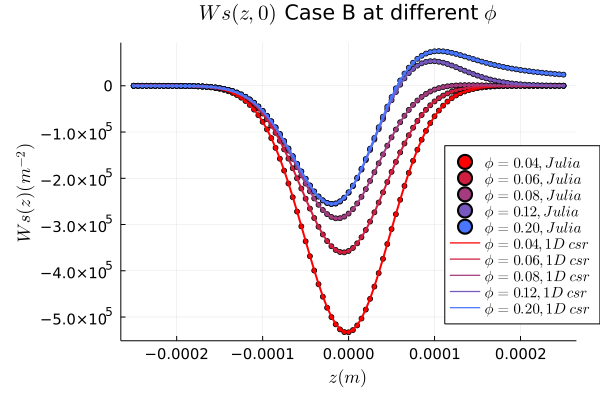

In [50]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)
plot(z_ob, Ws_caseB_mat_phi_004[102:202], label=L"\phi=0.04, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(z_ob, Ws_caseB_mat_phi_006[102:202], label=L"\phi=0.06, Julia", markersize = 3, seriestype = :scatter, color=cs1[2])
plot!(z_ob, Ws_caseB_mat_phi_008[102:202], label=L"\phi=0.08, Julia", markersize = 3, seriestype = :scatter, color=cs1[3])
plot!(z_ob, Ws_caseB_mat_phi_012[102:202], label=L"\phi=0.12, Julia", markersize = 3, seriestype = :scatter, color=cs1[4])
plot!(z_ob, Ws_caseB_mat_phi_02[102:202], label=L"\phi=0.20, Julia", markersize = 3, seriestype = :scatter, color=cs1[5])


plot!(z_ob, WsB_int_vec_1, linewidth=2, label=L"\phi=0.04, 1D~ csr", color=cs1[1])
plot!(z_ob, WsB_int_vec_2, linewidth=2, label=L"\phi=0.06, 1D~ csr", color=cs1[2])
plot!(z_ob, WsB_int_vec_3, linewidth=2, label=L"\phi=0.08, 1D~ csr", color=cs1[3])
plot!(z_ob, WsB_int_vec_4, linewidth=2, label=L"\phi=0.12, 1D~ csr", color=cs1[4])
plot!(z_ob, WsB_int_vec_5, linewidth=2, label=L"\phi=0.20, 1D~ csr", color=cs1[5])


plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,0)$ Case B at different $\phi$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=(0.8, 0.6), legendfontsize = 10)
#plot(z_ob, Ws_caseB_mat_phi_2[102:202], label=L"\phi=0.04, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])

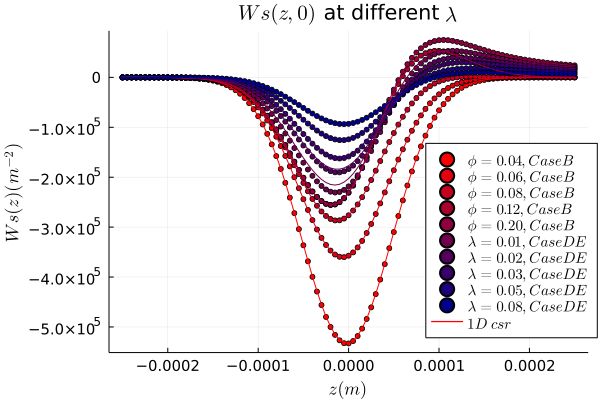

In [113]:
plot(z_ob, Ws_caseB_mat_phi_004[102:202], label=L"\phi=0.04, Case B", markersize = 3, seriestype = :scatter, color=cs3[1], order=2)
plot!(z_ob, Ws_caseB_mat_phi_006[102:202], label=L"\phi=0.06, Case B", markersize = 3, seriestype = :scatter, color=cs3[2], order=2)
plot!(z_ob, Ws_caseB_mat_phi_008[102:202], label=L"\phi=0.08, Case B", markersize = 3, seriestype = :scatter, color=cs3[3], order=2)
plot!(z_ob, Ws_caseB_mat_phi_012[102:202], label=L"\phi=0.12, Case B", markersize = 3, seriestype = :scatter, color=cs3[4], order=2)
plot!(z_ob, Ws_caseB_mat_phi_02[102:202], label=L"\phi=0.20, Case B", markersize = 3, seriestype = :scatter, color=cs3[5], order=2)

plot!(z_ob, Ws_caseDE_mat_lamb_001[102:202], linewidth=2, label=L"\lambda =0.01, Case DE", markersize = 3, seriestype = :scatter, color=cs3[6], order=2)
plot!(z_ob, Ws_caseDE_mat_lamb_002[102:202], linewidth=2, label=L"\lambda =0.02, Case DE", markersize = 3, seriestype = :scatter, color=cs3[7], order=2)
plot!(z_ob, Ws_caseDE_mat_lamb_003[102:202], linewidth=2, label=L"\lambda =0.03, Case DE", markersize = 3, seriestype = :scatter, color=cs3[8], order=2)
plot!(z_ob, Ws_caseDE_mat_lamb_005[102:202], linewidth=2, label=L"\lambda =0.05, Case DE", markersize = 3, seriestype = :scatter, color=cs3[9], order=2)
plot!(z_ob, Ws_caseDE_mat_lamb_008[102:202], linewidth=2, label=L"\lambda =0.08, Case DE", markersize = 3, seriestype = :scatter, color=cs3[10], order=2)


plot!(z_ob, WsB_int_vec_1, linewidth=1, label=L"1D~ csr", color=cs3[1], order=1)
plot!(z_ob, WsB_int_vec_2, linewidth=1, label=false, color=cs3[2], order=1)
plot!(z_ob, WsB_int_vec_3, linewidth=1, label=false, color=cs3[3], order=1)
plot!(z_ob, WsB_int_vec_4, linewidth=1, label=false, color=cs3[4], order=1)
plot!(z_ob, WsB_int_vec_5, linewidth=1, label=false, color=cs3[5], order=1)

plot!(z_ob, WsD_1D_vec_1, linewidth=1, label=false,color=cs3[6], order=1)
plot!(z_ob, WsD_1D_vec_2, linewidth=1, label=false, color=cs3[7], order=1)
plot!(z_ob, WsD_1D_vec_3, linewidth=1, label=false,color=cs3[8], order=1)
plot!(z_ob, WsD_1D_vec_4, linewidth=1, label=false,color=cs3[9], order=1)
plot!(z_ob, WsD_1D_vec_5, linewidth=1, label=false, color=cs3[10], order=1)

plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,0)$ at different $\lambda$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), legend=(0.75, 0.6), margin=1Plots.mm, legendfontsize = 10)

# 1D theory

In [42]:
using QuadGK

lamb_1d(z::Float64) = 1/(sigma_z*sqrt(2*pi))* exp(-z^2 / 2 / sigma_z^2)
lamb_1d_prime(z::Float64) = 1/(sigma_z*sqrt(2*pi))* exp(-z^2 / 2 / sigma_z^2) * (-z / sigma_z^2)

z_L(phi::Float64) = rho*phi^3/24
coeff = -2/(3*rho^2)^(1/3)


# Case B boundary term ( for large phi this vanishes )
function Ws_case_B_1D_theory_boundary_term(z_ob::Float64, phi::Float64)
    #alternative form
    #return -4/phi/rho * lamb_1d( z_ob - rho*phi^3/24 )
    zL =  z_L(phi)
    return coeff* lamb_1d( z_ob - zL ) / zL^(1/3)
end



# Case B integral term ( for large phi this becomes the s-s wake )
function Ws_case_B_1D_theory_integral_term(z_ob::Float64, phi::Float64)
    w_ss(zp) = lamb_1d_prime(zp)/(z_ob - zp)^(1/3)
    return coeff*quadgk(w_ss, z_ob - z_L(phi), z_ob)[1]
end

# Case B Wx
function Wx_case_B_1D_theory(z_ob::Float64, phi::Float64)
    #alternative form
    return -4/rho * lamb_1d( z_ob )
end


# Case D boundary term ( for large phi_m this vanishes )
function Ws_case_D_1D_theory_boundary_term(z_ob::Float64, lamb::Float64, phi_m::Float64)
    x =  lamb*rho
    Lm = phi_m*rho   
    delta_s(l) =  l^3/24/rho^2*(l + 4*x)/(l + x)
    
    return - 4 * lamb_1d(z_ob - delta_s(Lm))/(Lm + 2*x)
end

# Case D integral term
# Check Dave Sagan's paper for the change-of-variable version of the integral 
function Ws_case_D_1D_theory_integral_term(z_ob::Float64, lamb::Float64, phi_m::Float64)
    x =  lamb*rho
    Lm = phi_m*rho     
    delta_s(l) =  l^3/24/rho^2*(l + 4*x)/(l + x)
    delta_s_prime(l) = l^2/8/rho^2*(l + 2*x)^2/(l + x)^2  
    ii(l) =  - 4/(l+2*x)* lamb_1d_prime(z_ob-delta_s(l))*delta_s_prime(l)
    
    return quadgk( ii, 0, Lm )[1]
end

Ws_case_D_1D_theory_integral_term (generic function with 1 method)

In [44]:
phi_ob = 0.01
WsB_1D(z_ob::Float64) = Ws_case_B_1D_theory_boundary_term(z_ob, phi_ob) + Ws_case_B_1D_theory_integral_term(z_ob, phi_ob)
WsB_1D(0.0);

lamb_temp = 0.01
WsD_1D(z_ob::Float64) = Ws_case_D_1D_theory_boundary_term(z_ob, lamb_temp, phi_m) + Ws_case_D_1D_theory_integral_term(z_ob, lamb_temp, phi_m)
WsD_1D(0.0)

z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)


-0.00025:5.0e-6:0.00025

In [49]:
phi_vec = [0.04, 0.06, 0.08, 0.12, 0.2];
phi_ob  = phi_vec[1]
WsB_int_vec_1 = map(WsB_1D, z_ob);
phi_ob  = phi_vec[2]
WsB_int_vec_2 = map(WsB_1D, z_ob);
phi_ob  = phi_vec[3]
WsB_int_vec_3 = map(WsB_1D, z_ob);
phi_ob  = phi_vec[4]
WsB_int_vec_4 = map(WsB_1D, z_ob);
phi_ob  = phi_vec[5]
WsB_int_vec_5 = map(WsB_1D, z_ob);

In [45]:
lamb_vec = [0.01, 0.02, 0.03, 0.05, 0.08];
lamb_temp = lamb_vec[1]
WsD_1D_vec_1 = map(WsD_1D, z_ob);
lamb_temp = lamb_vec[2]
WsD_1D_vec_2 = map(WsD_1D, z_ob);
lamb_temp = lamb_vec[3]
WsD_1D_vec_3 = map(WsD_1D, z_ob);
lamb_temp = lamb_vec[4]
WsD_1D_vec_4 = map(WsD_1D, z_ob);
lamb_temp = lamb_vec[5]
WsD_1D_vec_5 = map(WsD_1D, z_ob);